# Généralisation

In [101]:
import numpy as np
from tqdm import tqdm 
from sklearn.datasets import make_circles
from sklearn.metrics import log_loss, accuracy_score
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

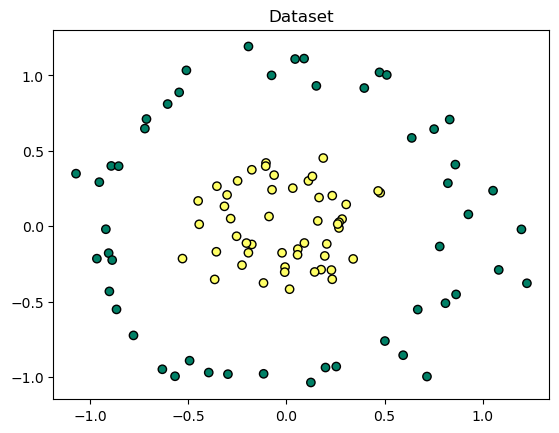

Dimensions de X: (2, 100)
Dimensions de y: (1, 100)


In [141]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=100, noise=0.1, factor=0.3)
X = X.T
y = y.reshape((1, y.shape[0]))

plt.scatter(X[0, :], X[1, :], c=y, cmap="summer", edgecolors='k')
plt.title("Dataset")
plt.show()

print("Dimensions de X:", X.shape)  # (2, n)
print("Dimensions de y:", y.shape)  # (1, n)


![w&b](multi_layer_png2/w&b.png "w&b")

In [103]:
def initialisation(dimensions):
    parametres = {} # On initialise un dictionnaire vide
    C = len(dimensions) # On récupère la len du tableau dimensions, car nous voulons accèder aux index

    for c in range(1, C): # On commence à 1 la boucle car la première entrée sont les entrés X et on arréte à C pour ne pas prendre le neuronne final (car python arrete à -1).
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1]) # Nouvelle clée, accès aux valeur de dimensions, création de la matrice.
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)
    return parametres

![z&c](multi_layer_png2/z&c.png "z&c")

In [104]:
def forward_propagation(X, parametres):
    C = len(parametres) // 2 # On divise avec 2 '/' pour retourner un nombre entier. Divise par deux pour obtenir le nombre de couche car il y a W et b dans la longueure.
    activations = {'A0' : X} # Car la première couche ce calcul avec les X, pas avec n-1.

    for c in range(1, C + 1): # Python s’arrete 1 nombre avant la fin de la boucle, donc C + 1 pour s’arréter à C
        Z = parametres['W' + str(c)] @ activations['A' + str(c - 1)] + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z)) # On append directement dans la boucel les A
    

    return activations

![back_propagation](multi_layer_png2/back_propagation.png "back_propagation")

In [105]:
def back_propagation(y, parametres, activations):

  m = y.shape[1]
  C = len(parametres) // 2

  dZ = activations['A' + str(C)] - y
  gradients = {}

  for c in reversed(range(1, C + 1)):
    gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
    gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    if c > 1:
      dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

  return gradients

![update](multi_layer_png2/update.png "update")

In [106]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [107]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af >= 0.5

In [108]:
def plot_results(X, y, training_history, parametres):
    # Génération des coordonnées de la grille pour la frontière de décision
    x_min, x_max = X[0, :].min() - 0.2, X[0, :].max() + 0.2
    y_min, y_max = X[1, :].min() - 0.2, X[1, :].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Prédiction sur la grille
    grid_points = np.c_[xx.ravel(), yy.ravel()].T  # Transformer en (2, n)
    Z = predict(grid_points, parametres)  # Prédiction
    Z = Z.reshape(xx.shape)  # Reformater pour correspondre à la grille

    # Affichage des résultats
    plt.figure(figsize=(16, 5))  # Ajustement de la taille

    # 1. Courbe de log_loss
    plt.subplot(1, 3, 1)
    plt.plot(training_history[:, 0], label='Train Loss')
    plt.legend()
    plt.title("Log Loss")

    # 2. Courbe d'accuracy
    plt.subplot(1, 3, 2)
    plt.plot(training_history[:, 1], label='Train Accuracy')
    plt.legend()
    plt.title("Accuracy")

    # 3. Frontière de décision
    plt.subplot(1, 3, 3)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="summer")  # Zones de classification
    plt.scatter(X[0, :], X[1, :], c=y, cmap="summer", edgecolors='k')  # Points réels
    plt.title("Frontière de Décision")

    plt.show()  # Afficher le tout

In [118]:
def neural_network(X, y, hidden_layers=(32, 32, 32), learning_rate=0.1, n_iter=1000):

    # Initialisation des paramètres
    dimensions = list(hidden_layers)  # Convertir en liste modifiable
    dimensions.insert(0, X.shape[0])  # Ajouter la dimension d'entrée
    dimensions.append(y.shape[0])  # Ajouter la dimension de sortie
    parametres = initialisation(dimensions)  # Initialisation des poids et biais

    training_history = np.zeros((int(n_iter), 2))
    C = len(parametres) // 2  # Nombre de couches

    # Descente de gradient
    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

        # Calcul du log_loss et de l'accuracy
        training_history[i, 0] = log_loss(y.flatten(), Af.flatten())
        y_pred = predict(X, parametres)
        training_history[i, 1] = accuracy_score(y.flatten(), y_pred.flatten())

    plot_results(X, y, training_history, parametres)

    return training_history

100%|██████████| 3000/3000 [00:02<00:00, 1004.24it/s]


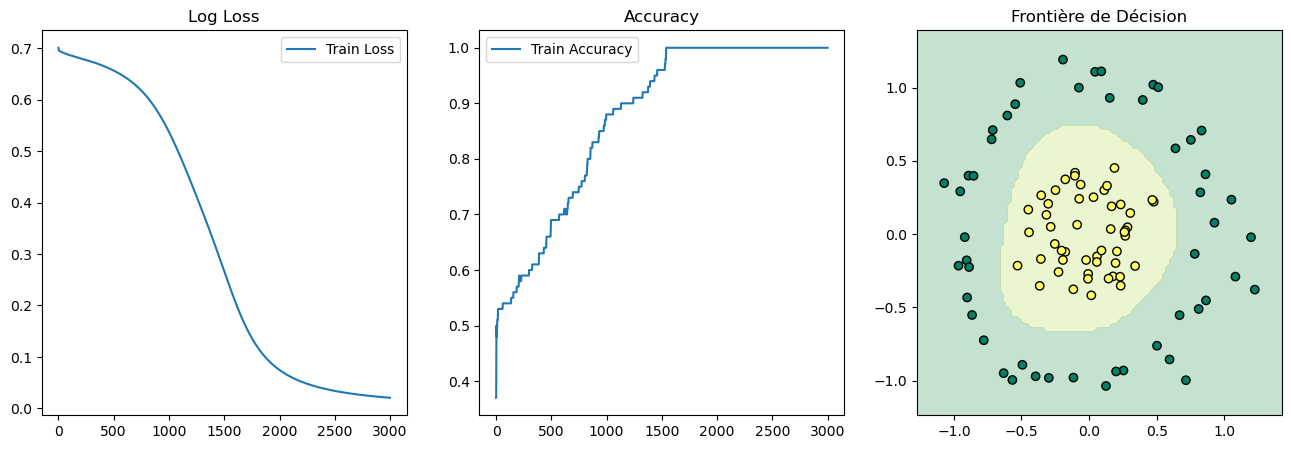

In [142]:
_ = neural_network(X, y, hidden_layers = (16, 16, 16), learning_rate = 0.1, n_iter = 3000)